In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/guitarsounds')
%load_ext autoreload

In [2]:
%autoreload 2
from guitarsounds import Sound, Signal
import guitarsounds as guit

In [3]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d, make_interp_spline
from scipy.optimize import least_squares

# Developping the frequency-damping plot
## Polynomial least squares curve fitting

In [72]:
def nth_order_polynomial_residual(A, n, x, y):
    if n<=len(y):
        y_model = 0
        for i in np.arange(n):
            y_model += A[i] * np.array(x) ** i
    return y_model - y

def nth_order_polynomial_fit(n, x, y):
    n += 1
    guess = np.ones(n)
    notdone = True
    while notdone:
        try:
            result = least_squares(nth_order_polynomial_residual, guess, args = (n, x, y))
            notdone = False
        except UnboundLocalError:
            n -= 1
        
    A = result.x
    
    def polynomial_function(x):
        y = 0
        for i, a in enumerate(A):
            y += a * np.array(x) ** i
        return y
    return polynomial_function

## Testing the function

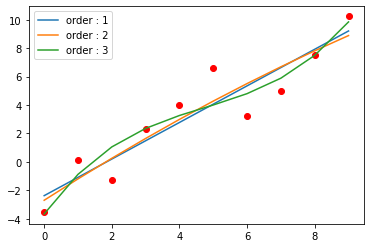

In [36]:
x = np.arange(10)
y = np.arange(10) + 4*np.random.rand(10) - 4*np.random.rand(10)

plt.scatter(x,y, c='r')
fun1 = nth_order_polynomial_fit(1, x, y)
fun2 = nth_order_polynomial_fit(2, x, y)
fun3 = nth_order_polynomial_fit(3, x, y)

for n, fun in enumerate([fun1, fun2, fun3]):
    plt.plot(x, fun(x), label = 'order : ' + str(n+1))

plt.legend()
plt.show()

## Testing with the frequency-damping scatter

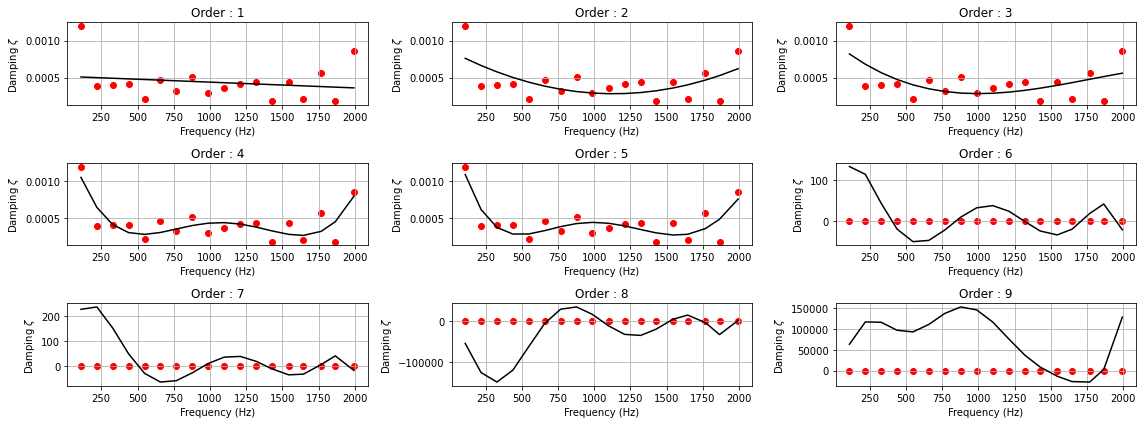

In [58]:
sound = Sound('soundfiles/flax_carbon/Wood_A0_1.wav')
sound.condition()

# Courbe damping-fréquence
fft = sound.signal.fft()[:len(sound.signal.fft())//2]
fft_freq = sound.signal.fft_frequencies()
peaks = sound.signal.peaks()
peak_freqs = []
zetas = []

for peak in peaks:
    peak_frequency = fft_freq[peak]
    peak_height = fft[peak]
    root_height = peak_height/np.sqrt(2)
    frequency_roots = InterpolatedUnivariateSpline(fft_freq, fft-root_height).roots()
    sorted_roots_indexes = np.argsort(np.abs(frequency_roots-peak_frequency))
    w2, w1 = frequency_roots[sorted_roots_indexes[:2]]
    w1, w2 = np.sort([w1, w2])
    zeta = (w2 - w1)/(2*peak_frequency)
    zetas.append(zeta)
    peak_freqs.append(peak_frequency)

fig, axs = plt.subplots(3, 3, figsize=(16,6))

for n, ax in enumerate(axs.reshape(-1)):
    # First plot
    ax.scatter(peak_freqs, zetas, c='r')
    fun = nth_order_polynomial_fit(n+1, peak_freqs, zetas)
    ax.plot(peak_freqs, fun(peak_freqs), c='k')
    ax.grid('on')
    ax.set_title('Order : ' + str(n+1))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(r'Damping $\zeta$')

plt.tight_layout()
plt.show()

## Testing with multiple signals

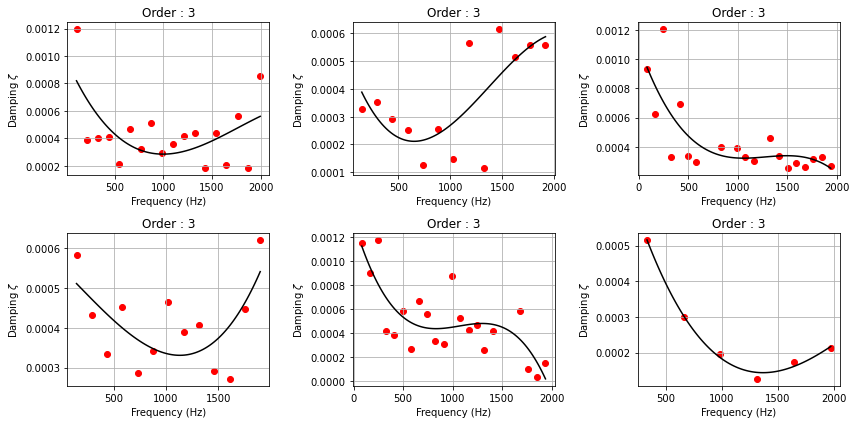

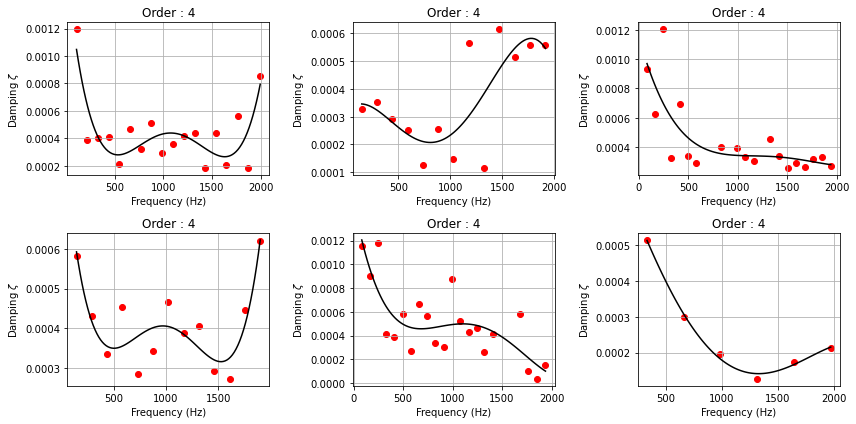

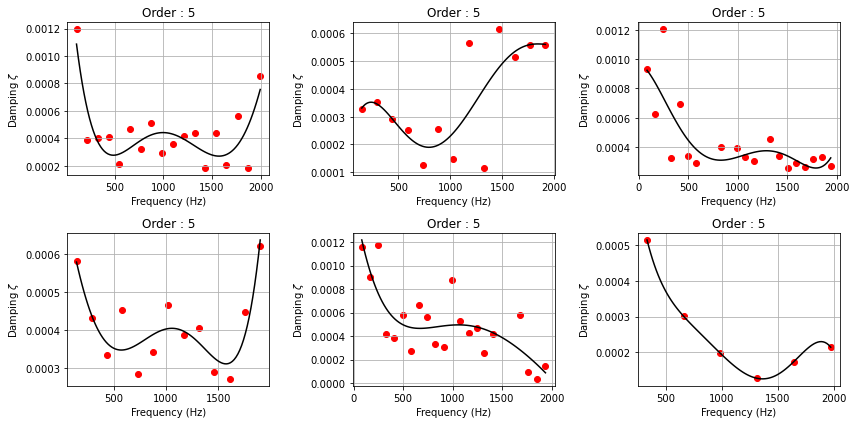

In [78]:
file1 = 'soundfiles/flax_carbon/Wood_A0_1.wav'
file2 = 'soundfiles/flax_carbon/Carbon_D0_2.wav'
file3 = 'soundfiles/flax_carbon/Carbon_E0_1.wav'
file4 = 'soundfiles/flax_carbon/Wood_D0_2.wav'
file5 = 'soundfiles/flax_carbon/Wood_E0_1.wav'
file6 = 'soundfiles/flax_carbon/Wood_E1_1.wav'
files = [file1, file2, file3, file4, file5, file6]

sounds = [Sound(file).condition(return_self=True) for file in files]

for n in np.arange(3,6):
    fig, axs = plt.subplots(2,3, figsize=(12,6))
    axs = axs.reshape(-1)

    for sound, ax in zip(sounds, axs):
        fft_freq = sound.signal.fft_frequencies()
        peaks = sound.signal.peaks()
        peak_freqs = fft_freq[peaks]
        zetas = sound.signal.peak_damping()
        ax.scatter(peak_freqs, zetas, c='r')
        fun = nth_order_polynomial_fit(n, peak_freqs, zetas)
        freq = np.linspace(peak_freqs[0], peak_freqs[-1], 100)
        ax.plot(freq, fun(freq), c='k')
        ax.grid('on')
        ax.set_title('Order : ' + str(n))
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel(r'Damping $\zeta$')
        
    plt.tight_layout()

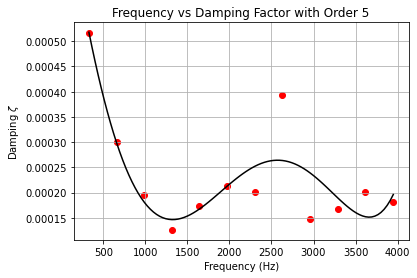

In [107]:
sound.signal.plot('peak damping')

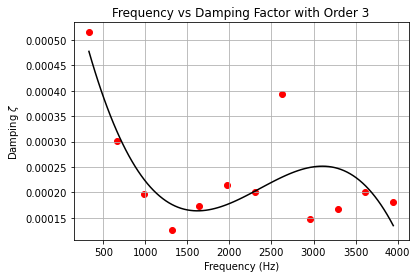

In [108]:
sound.signal.plot('peak damping', n=3)

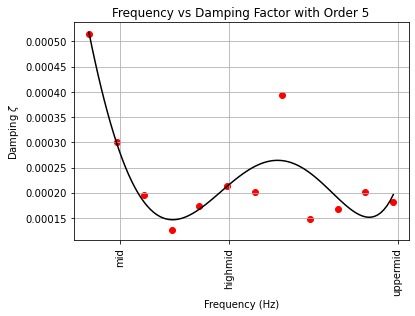

In [109]:
sound.SP.change('fft_range', 4000)
sound.signal.plot('peak damping', ticks='bins')

### 2. Comparing two materials

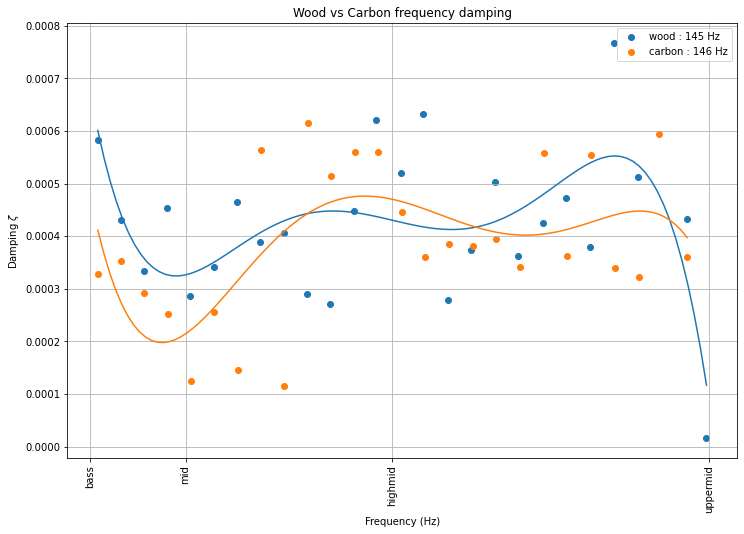

In [5]:
# TODO replace damping with Quality factor

carbonfile = 'soundfiles/flax_carbon/Carbon_D0_2.wav'
woodfile = 'soundfiles/flax_carbon/Wood_D0_2.wav'

carbon = Sound(carbonfile, name='carbon').condition(return_self=True)
carbon.SP.change('fft_range', 4000)
wood = Sound(woodfile, name='wood').condition(return_self=True)
wood.SP.change('fft_range', 4000)

plt.figure(figsize=(12,8))
wood.signal.plot('peak damping', label = wood.name + ' : ' + str(int(wood.signal.fundamental())) + ' Hz')
carbon.signal.plot('peak damping', label = carbon.name + ' : ' + str(int(carbon.signal.fundamental())) + ' Hz', ticks='bins')
plt.legend()
plt.title('Wood vs Carbon frequency damping')
plt.show()

### 3. Works for plates ?

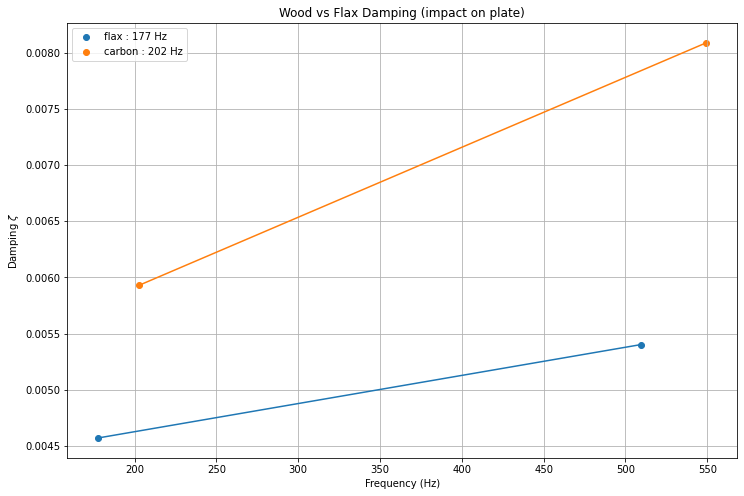

In [6]:
carbonfile = 'soundfiles/flax_carbon/Carbon.wav'
flaxfile = 'soundfiles/flax_carbon/Flax.wav'

carbon = Sound(carbonfile, name='carbon').condition(return_self=True)
carbon.SP.change('fft_range', 580)
flax = Sound(flaxfile, name='flax').condition(return_self=True)
flax.SP.change('fft_range', 580)

plt.figure(figsize=(12,8))
flax.signal.plot('peak damping', label = flax.name + ' : ' + str(int(flax.signal.fundamental())) + ' Hz')
carbon.signal.plot('peak damping', label = carbon.name + ' : ' + str(int(carbon.signal.fundamental())) + ' Hz')
plt.legend()
plt.title('Wood vs Flax Damping (impact on plate)')
plt.show()